In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from tsai.all import *

torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import psutil
import requests

from utils import *
from wingbeat_datasets import *
from wingbeat_models import *

print(f'Total RAM      : {bytes2GB(psutil.virtual_memory().total):5.2f} GB')
print(f'Available RAM  : {bytes2GB(psutil.virtual_memory().available):5.2f} GB\n')

/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Available workers: 16
Total RAM      : 31.17 GB
Available RAM  : 24.42 GB



In [3]:
num_epochs = 35
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'raw'
modeltype = 'conv1draw'
normalize = ""#"sample"

In [4]:
transforms_list = [FilterWingbeat(setting='bandpass')]

if normalize == "whole":
    dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Y", clean=True,transform=transforms.Compose(transforms_list))
    dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/L", clean=True, transform=transforms.Compose(transforms_list))
    transformed_dataset = ConcatDataset([dmel1, dsuz1])
    trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)

    mean, std = calc_mean_std_1D(loader=trainval_dataloader)
    transforms_list += [Normalize(mean=mean, std=std, axes=(0,2))]
elif normalize == "sample":
    transforms_list += [Normalize()]
else:
    pass

dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dmel2 = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/Y",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
dsuz2 = WingbeatsDataset(dsname="Suzukii_RL/X",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))

Found 12150 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 12003 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 18166 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Found 14703 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


In [8]:
dmel1.parse_filenames()
dmel2.parse_filenames()
dsuz1.parse_filenames()
dsuz2.parse_filenames()

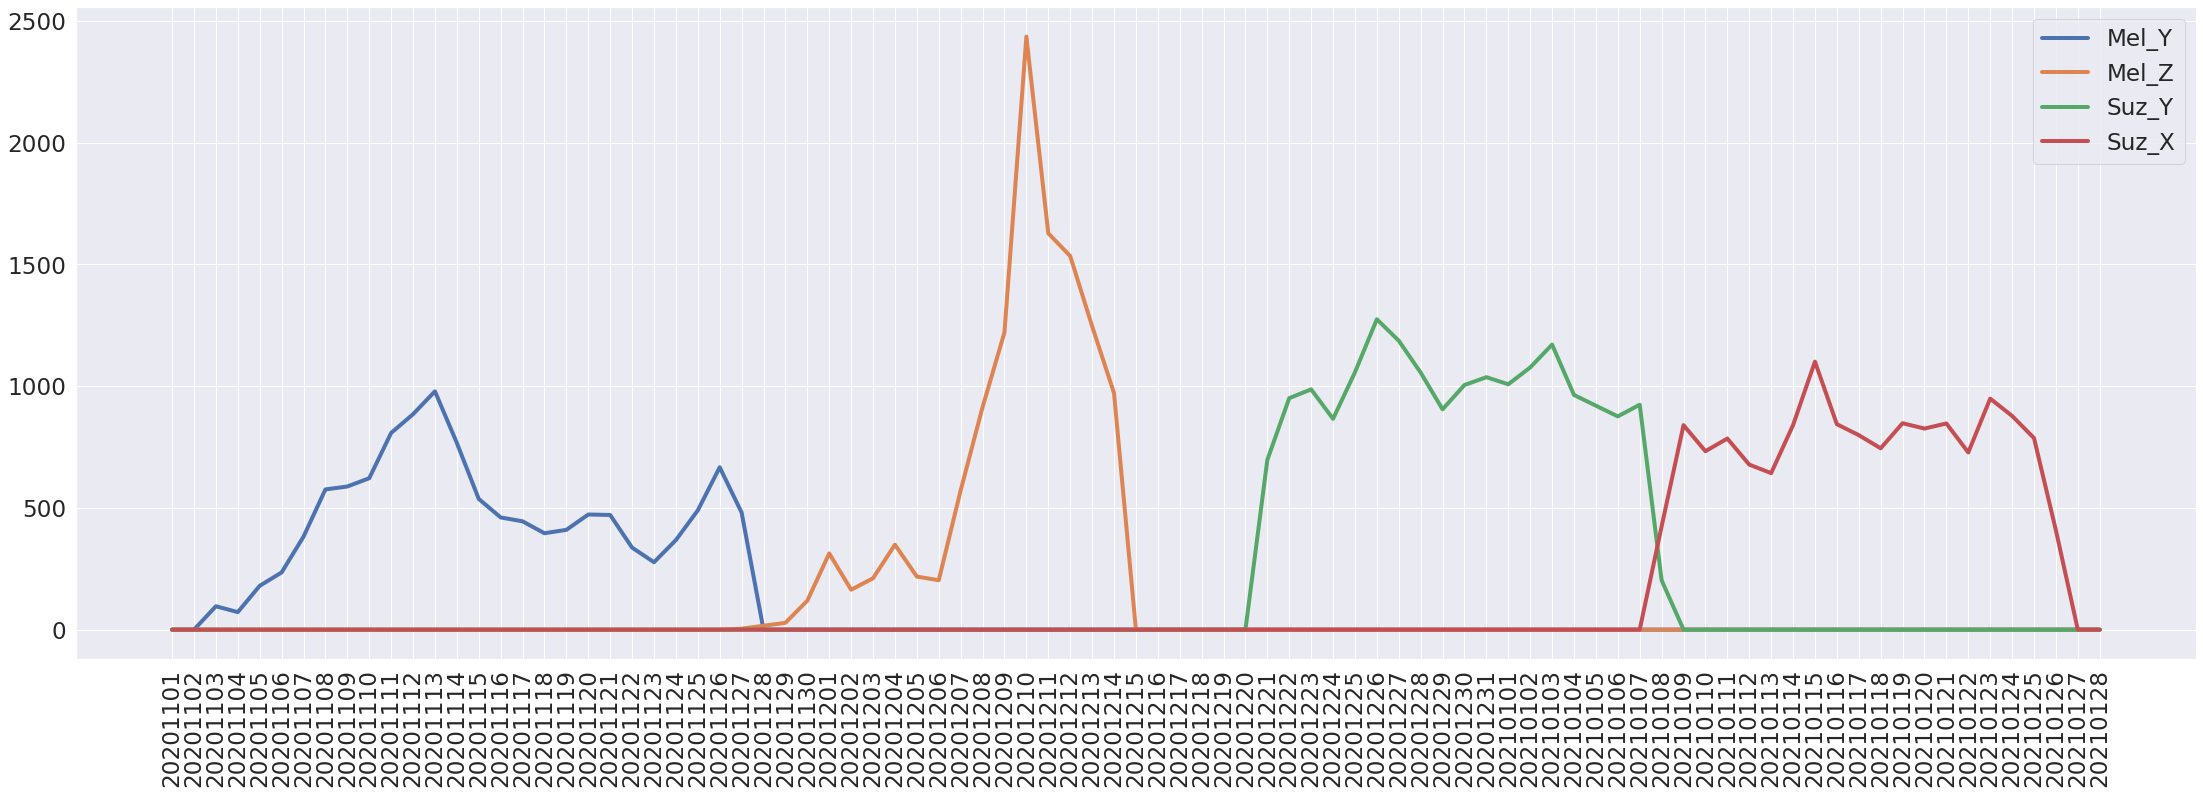

In [20]:
import seaborn as sns
sns.set(font_scale=2.1)

start='20201101' 
end='20210128'
figx=12
figy=38

dmel2.plot_daterange(start=start, end=end, figx=figx, figy=figy)
dmel1.plot_daterange(start=start, end=end, figx=figx, figy=figy)
dsuz1.plot_daterange(start=start, end=end, figx=figx, figy=figy)
dsuz2.plot_daterange(start=start, end=end, figx=figx, figy=figy)


plt.legend(['Mel_Y','Mel_Z','Suz_Y','Suz_X']);

plt.savefig('/home/kalfasyan/Dropbox/to_send/date_range_train_test.png', bbox_inches='tight', format='png')

In [21]:
ds1 = WingbeatsDataset(dsname="Suzukii_RL/R", custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
ds2 = WingbeatsDataset(dsname="Suzukii_RL/L", custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
ds3 = WingbeatsDataset(dsname="Melanogaster_RL/X", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
ds4 = WingbeatsDataset(dsname="Melanogaster_RL/W", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))

Found 10110 in dataset: Suzukii_RL/R, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Found 14156 in dataset: Suzukii_RL/L, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Found 407 in dataset: Melanogaster_RL/X, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 742 in dataset: Melanogaster_RL/W, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]


In [22]:
ds1.parse_filenames()
ds2.parse_filenames()
ds3.parse_filenames()
ds4.parse_filenames()

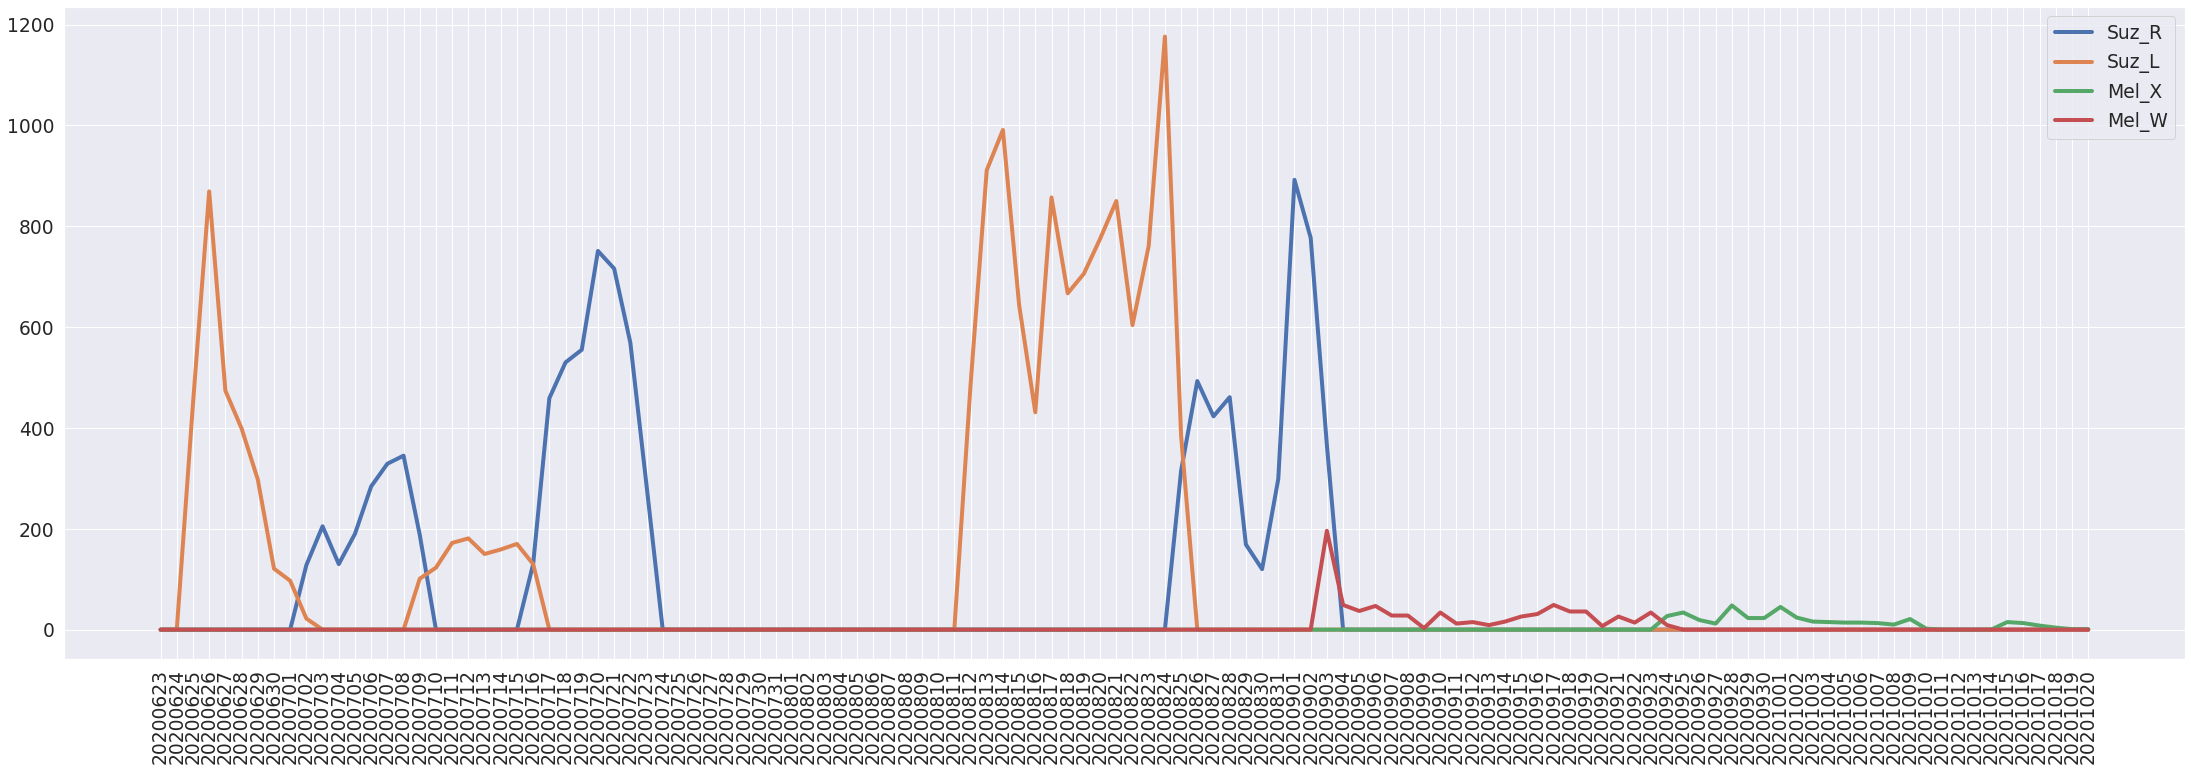

In [28]:
import seaborn as sns
sns.set(font_scale=1.7)

start='20200623' 
end='20201020'
figx=12
figy=38

ds1.plot_daterange(start=start, end=end, figx=figx, figy=figy)
ds2.plot_daterange(start=start, end=end, figx=figx, figy=figy)
ds3.plot_daterange(start=start, end=end, figx=figx, figy=figy)
ds4.plot_daterange(start=start, end=end, figx=figx, figy=figy)


plt.legend(['Suz_R','Suz_L','Mel_X','Mel_W']);

plt.savefig('/home/kalfasyan/Dropbox/to_send/date_range_mebios.png', bbox_inches='tight', format='png')